# TreeSHAP-IQ for LightGBM

In this example, we use the popular Adult census dataset for classification available at https://archive.ics.uci.edu/ml/datasets/adult.

### import packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm

import shapiq

shapiq.__version__

'0.1.0'

### load data

In [2]:
X, y = shapiq.load_adult_census()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### train a model

In [3]:
model = lightgbm.LGBMClassifier(n_estimators=500, max_depth=n_features, random_state=42, verbose=-1)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.9229
Test  R2: 0.8702


### (model-)specific explainer for tree-based models

We use `shapiq.TreeExplainer` to explain a tree-ensemble model for tabular data. 

It has the following basic parameters:
- `model`: The model to be explained.
- `max_order`: The maximum interaction order to be computed. An interaction order of 1 corresponds to the Shapley value. 

    Any value higher than 1 computes the Shapley interaction values up to that order. Defaults to 2.
- `min_order`: The minimum interaction order to be computed. Defaults to 1.
- `index`: The interactio index to be computed. It can be one of:

    "k-SII" (default), "SII", "STII", "FSII", or "BZF". Note that all indices apart from "BZF" will reduce to the "SV" (Shapley value) for order 1.

In [4]:
explainer = shapiq.TreeExplainer(model=model, index="k-SII", min_order=1, max_order=3)

Next, select an instance to be explained.

In [5]:
x = X_test[1234]

Call the `explain()` interface.

In [6]:
interaction_values = explainer.explain(x)
interaction_values

InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=False, estimation_budget=None,
    n_players=14, baseline_value=-2.7304417605285356
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=False, estimation_budget=None,
    n_players=14, baseline_value=-2.7304417605285356,
    Top 10 interactions:
        (13,): 1.3243985663352291
        (0,): 1.1892167650631034
        (4, 13): 0.5012954622661242
        (8,): 0.3990992018257262
        (4, 8): 0.3122120614824553
        (0, 5, 13): 0.29666949590768704
        (1,): -0.3617227215026871
        (9,): -0.4781028151117917
        (7,): -0.8966992722570122
        (): -2.7304417605285356
)


One can retrieve only 1-order values with `get_n_order(1)` (object) and `get_n_order_values(1)` (values themselves).

In [8]:
interaction_values.get_n_order(1).dict_values

{(0,): 1.1892167650631034,
 (1,): -0.3617227215026871,
 (2,): -0.069188692657852,
 (3,): 0.03140676551933795,
 (4,): 0.05955011146405047,
 (5,): 0.0595515687931342,
 (6,): 0.0011780513666978863,
 (7,): -0.8966992722570122,
 (8,): 0.3990992018257262,
 (9,): -0.4781028151117917,
 (10,): 0.03481381670916736,
 (11,): 0.19966462358131734,
 (12,): 0.018493333314310408,
 (13,): 1.3243985663352291}

In [9]:
interaction_values.get_n_order_values(2).shape

(14, 14)

### visualization of Shapley interactions

`shapiq` includes the following plotting functions:
- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

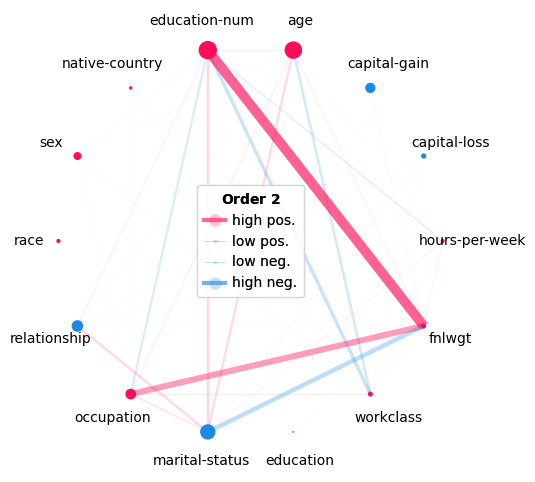

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

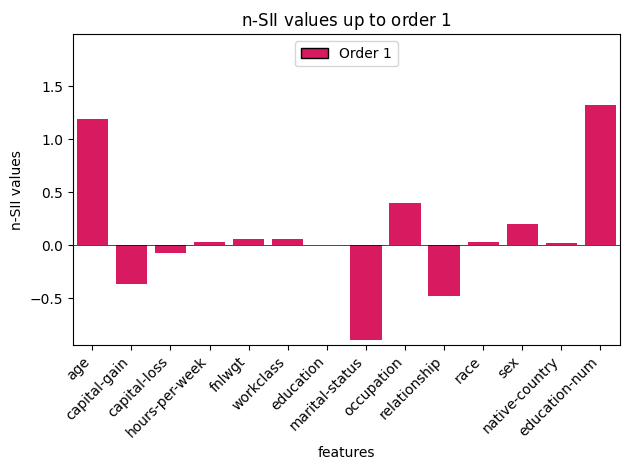

In [11]:
_ = shapiq.stacked_bar_plot(
    n_shapley_values_pos={
        1: np.array([0 if x < 0 else x for x in interaction_values.get_n_order_values(1)])
    },
    n_shapley_values_neg={
        1: np.array([0 if x > 0 else x for x in interaction_values.get_n_order_values(1)])
    },
    feature_names=X.columns,
)

After installing the `shap` Python package.

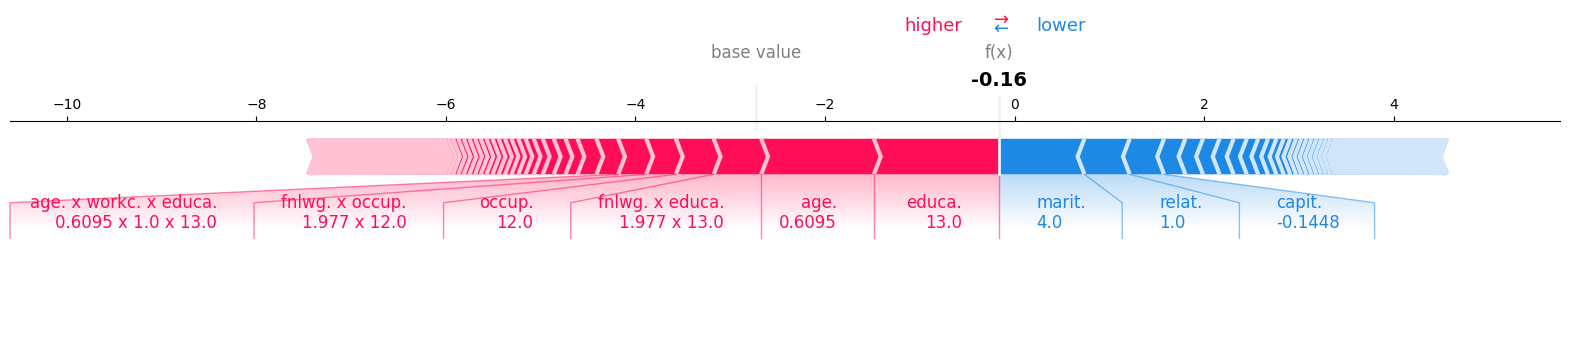

In [12]:
interaction_values.plot_force(
    feature_names=X.columns, 
    feature_values=x, 
    contribution_threshold=0.03
)

### global feature (interaction) importance

We can compute interaction values for a set of samples and visualize their global aggregation.

In [13]:
list_of_interaction_values = explainer.explain_X(X_test[:128,])

In [14]:
len(list_of_interaction_values) == 128

True

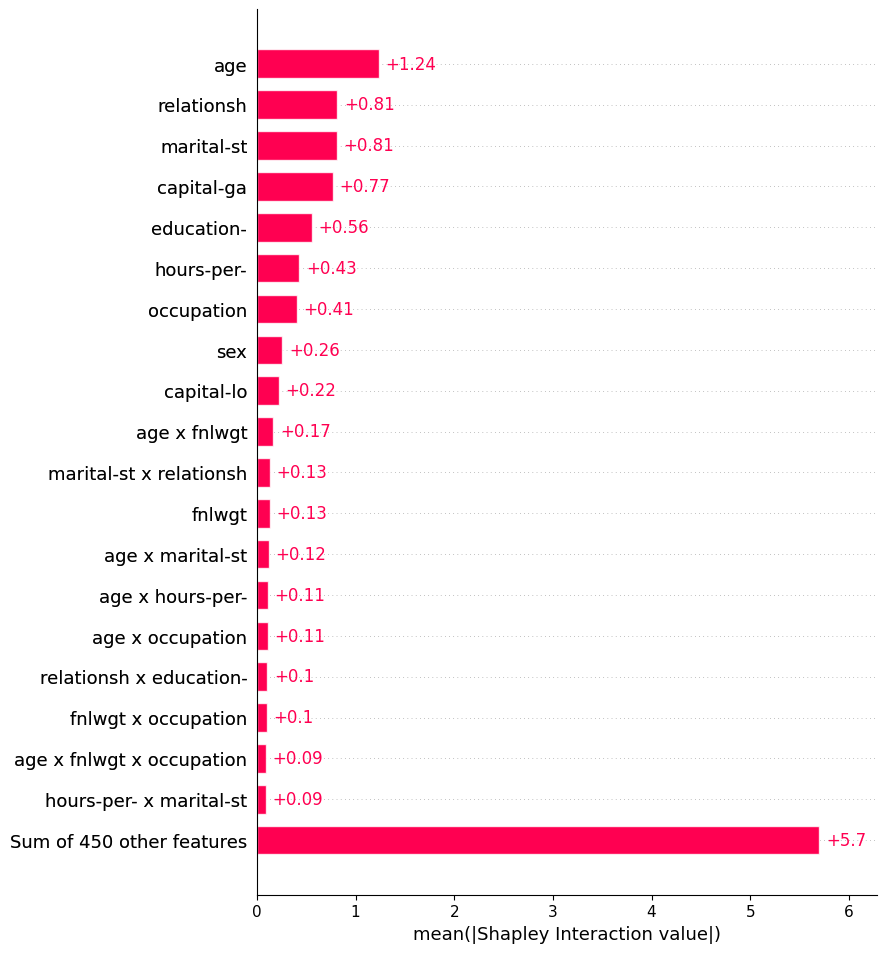

In [15]:
shapiq.plot.bar_plot(
    list_of_interaction_values,
    feature_names=X.columns,
    max_display=20
)